In [178]:
import tensorflow as tf

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

print (tf.__version__)

2.8.0


In [179]:
# import FASHION MNIST
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_img, train_lbl), (tst_img, tst_lbl) = fashion_mnist.load_data()

In [180]:
class_names = ['T-shirt', 'trouser', 'hoodie', 'dress', 'coat', 
               'sandal', 'shirt', 'sneaker', 'bag', 'hightop shoes']

In [181]:
# 60k training imgs in the training set with each img represented as 28x28pix
train_img.shape

(60000, 28, 28)

In [182]:
# 60k training lbls
len(train_lbl)

60000

In [183]:
train_lbl

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [184]:
tst_img.shape 

(10000, 28, 28)

In [185]:
len(tst_lbl)

10000

# Preprocess the Data 

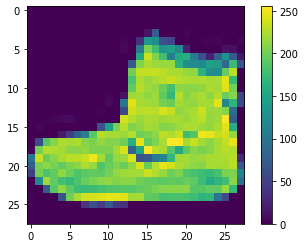

In [186]:
# the pix value goes form 0 to 255
plt.figure()
plt.imshow(train_img[0])
plt.colorbar()
plt.grid(False)
# plt.xlabel(class_names[train_lbl[0]])
plt.show()


In [187]:
# scaling values to range of 0 to 1. 
train_img = train_img / 255.0
tst_img = tst_img / 255.0

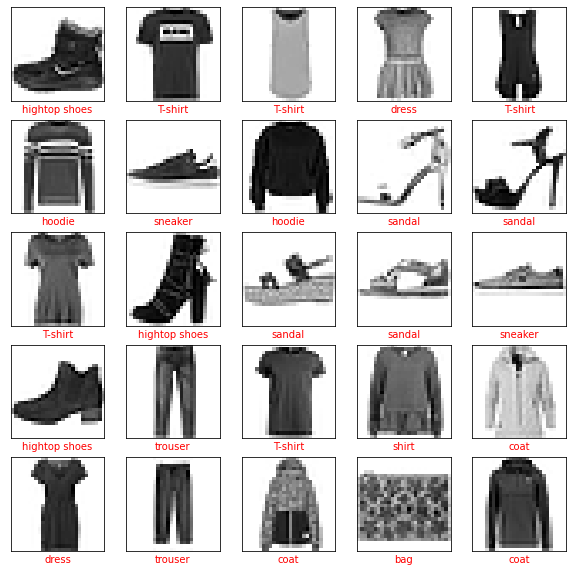

In [199]:
plt.figure(figsize = (10,10))
for i in range(25):
    ax = plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_img[i], cmap = plt.cm.binary)
    plt.xlabel(class_names[train_lbl[i]])
    ax.xaxis.label.set_color('red')
plt.show()

# Build Model
### layer setup

In [189]:
# 3 layers network model
model = tf.keras.Sequential([
    # first layer for flattening
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    # 1 hidden layer with 128 nodes
    tf.keras.layers.Dense(128, activation = 'relu'),
    # 1 output layer
    tf.keras.layers.Dense(10)
])

### model compiling

In [190]:
model.compile(
    # how the model is update based on the data it sees and its loss function
    optimizer = 'adam',
    # measures how accurate the model is in the training
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True),
    # monitors the training and testing step. 
    # uses accuracy, the fration of the img that are correctly classified
    metrics = ['accuracy']
)

In [191]:
model.fit(train_img, train_lbl, epochs = 10)

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5028 - accuracy: 0.8225
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3780 - accuracy: 0.8651
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3390 - accuracy: 0.8760
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3145 - accuracy: 0.8845
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2967 - accuracy: 0.8899
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2793 - accuracy: 0.8971
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2668 - accuracy: 0.9003
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2579 - accuracy: 0.9044
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2459 - accuracy: 0.9086
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.239

### accuracy evaluation

In [192]:
tst_loss, tst_acc = model.evaluate(tst_img, tst_lbl, verbose = 2)
print('\nTest Acc: ', tst_acc)

313/313 - 0s - loss: 0.3378 - accuracy: 0.8826 - 461ms/epoch - 1ms/step

Test Acc:  0.8826000094413757


In [193]:
#function for plotting the image and the prediction
def plt_img(i, pred_arr, tru_lbl, img):
    tru_lbl, img = tru_lbl[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap = plt.cm.binary)
    
    pred_lbl= np.argmax(pred_arr)
    if pred_lbl == tru_lbl: 
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel(
        "{} {:2.0f}% ({})".format(
            class_names[pred_lbl],
            100*np.max(pred_arr),
            class_names[tru_lbl]),
        color = color
    )


def plt_val_arr(i, pred_arr, tru_lbl):
    tru_lbl = tru_lbl[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplt = plt.bar(range(10),pred_arr, color = "#777777")
    plt.ylim([0,1])
    pred_lbl = np.argmax(pred_arr)
    
    thisplt[pred_lbl].set_color('red')
    thisplt[tru_lbl].set_color('green')       

# Adversarial Img Gen

In [194]:
prob_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])

In [195]:
# model doesnt take tst_img[0], so expanded the dimensions
pred = prob_model.predict(tf.expand_dims(tst_img[0], axis = 0))

In [196]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True)

def create_adversarial_pattern(input_image, input_label):
    input_image = tf.convert_to_tensor(input_image, np.float32)
  
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = prob_model(tf.expand_dims(input_image, axis = 0))
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

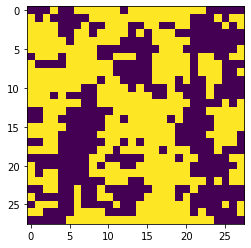

In [197]:
# Get the input label of the image.
sandal = 9999

perturbations = create_adversarial_pattern(tst_img[sandal], tst_lbl[sandal])
plt.imshow(perturbations/225);  # To change [-1, 1] to [0,1]

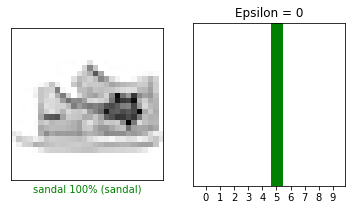

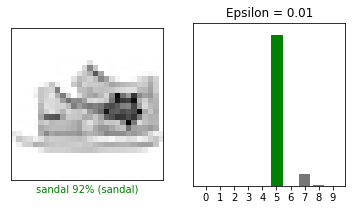

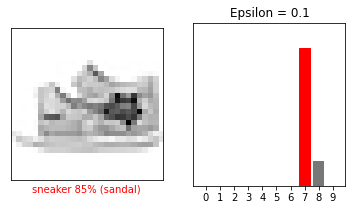

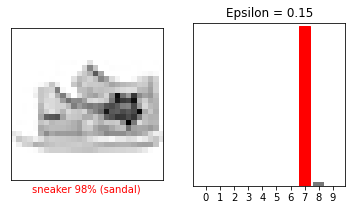

In [198]:
epsilons = [0, 0.01, 0.1, 0.15]

for i, eps in enumerate(epsilons):
    adv_x = tst_img[sandal] + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    predictions = prob_model(tf.expand_dims(adv_x, axis=0))
    plt.figure(figsize = (6,3))
    plt.subplot(1,2,1)
    plt_img(sandal, predictions[0], tst_lbl, tst_img)
    plt.subplot(1,2,2)
    plt_val_arr(sandal, predictions[0], tst_lbl)
    plt.show
    plt.title(f'Epsilon = {eps}')